![](header.jpg)

# Quaternions

Kevin Walchko

25 June 2022

---

On Monday 16 October 1843 in Dublin, when Hamilton was on his way to the Royal Irish Academy where he was going to preside at a council meeting. As he walked along the towpath of the Royal Canal with his wife, the concepts behind quaternions were taking shape in his mind. When the answer dawned on him, Hamilton could not resist the urge to carve the formula for the quaternions,

$$
\mathbf {i}^{2} = \mathbf{j}^{2} = \mathbf{k}^{2} = \mathbf{i\,j\,k} = -1
$$

into the stone of Brougham Bridge as he paused on it. 

Hamilton describes a quaternion $q=a+b\,\mathbf {i} +c\,\mathbf {j} +d\,\mathbf {k}$, as consisting of a scalar part and a vector part. The quaternion $b\,\mathbf {i} +c\,\mathbf {j} +d\,\mathbf {k}$ is called the vector part (imaginary part) of $q$, and $a$ is the scalar part (real part) of $q$.

## References

- wikipedia: [Quaternion](https://en.wikipedia.org/wiki/Quaternion)
- F. Landis Markley, "Attitude Error Representations for Kalman Filtering", https://ntrs.nasa.gov/api/citations/20020060647/downloads/20020060647.pdf
- wolfram: [Quaternion](https://mathworld.wolfram.com/Quaternion.html)
- wikipedia: [Quaternion](https://en.wikipedia.org/wiki/Quaternion)

## Quaternions

Euler angles have many problems so they are typically not used in Aerospace, virtual reality or video games to represent attitude (or rigid body orientation). Typically you use a Quaternion to represent 3D space with a 4D vector ($\mathbb{R}^3 \Leftrightarrow \mathbb{R}^4$). There are different representations of quaternions, but Sola compares two forms:

| Characteristics    | Hamilton                          | JPL |
|--------------------|-----------------------------------|-----|
| Component Order    | $[q_w, q_{xyz}]$                  | $[q_{xyz}, q_w]$ |
| Algebra Handedness | $\hat i \cdot \hat j = \hat k$ (right-handed)     | $\hat i \cdot \hat j = - \hat k$ (left-handed) |
| Rotation           | local-to-global                   | global-to-local |
| Default Operation  | $x_G = q \otimes x_L \otimes q^*$ | $x_L = q \otimes x_G \otimes q^*$ | 

Here we are using the Hamilton definition of a quaternion.

$$
\begin{array}
q &= \begin{bmatrix} w & x & y & z \end{bmatrix} \\
  &= \begin{bmatrix} q_w & q_{x,y,z} \end{bmatrix}
\end{array} \\
\mathbb{Re}(q) = q_w = \cos (\theta / 2) \\
\mathbb{Im}(q) = q_{x,y,z} = \hat e \sin (\theta / 2) \\
q^{-1} = q^* = \begin{bmatrix} q_w & -q_x & -q_y & -q_z \end{bmatrix}
$$

where the quaternion represents a rotation ($\theta$) about an axis ($\hat e$). The quaternion is also composed of a real part ($q_w$) and an imaginary part ($q_{xyz}$).

$$
\dot q_w = - \frac {1}{2} \omega^T q_{xyz} \\
\dot q_{xyz} = \frac{1}{2} (\omega q_w - \omega \times q_{xyz}) \quad \textrm{or} \quad
\dot q_{xyz} = \frac{1}{2} (q_{xyz} \times \omega + q_w \omega)
$$

Now, sometimes authors will use $q_{xyz}^x$ or $\omega^x$ to get rid of the cross product and use a skew matrix instead. There is no advantage unless you are trying to fit it into a matrix operations for notation reasons.

Attitude matrix which works for both q and -q is:

$$
A(q) = (q_w^2 - |q_{xyz}|^2) I_{3x3} - 2 q_w [q_{xyz}^x] + 2q_{xyz} q_{xyz}^T \\
A(p)A(q) = A(p \otimes q) \\
A(p)A(q) = A(qp)
$$

Note, the $qp$ above is via the process of changeing quaternion multiplication $\otimes$ into a matrix vector multiplication where the order is swapped in the process.

$$
p \otimes q = \begin{bmatrix}
    p_w q_w - p_{xyz}^T q_{xyz} \\
    p_w q_{xyz} + q_w p_{xyz} - p_{xyz} \times q_{xyz}
\end{bmatrix} \\
p \otimes q = qp
$$

Now, one more thing, if we look at the $\dot q$ equations above again with this definition of quaternion multiplication, we can see:

$$
\dot q = \frac {1}{2} q \otimes \omega \\
q \otimes \omega = p \otimes q = \begin{bmatrix}
    p_w q_w - p_{xyz}^T q_{xyz} \\
    p_w q_{xyz} + q_w p_{xyz} - p_{xyz} \times q_{xyz}
\end{bmatrix} \Leftarrow \left\{ \begin{array}
    . q = \begin{bmatrix} 0 & \omega_x & \omega_y & \omega_z \end{bmatrix}^T \\
    p = q_s 
\end{array} \right. \\
p \otimes q = \begin{bmatrix}
    p_w 0 - p_{xyz}^T q_{xyz} \\
    p_w q_{xyz} + 0 p_{xyz} - p_{xyz} \times q_{xyz}
\end{bmatrix}  \\
\dot q = \frac {1}{2} \begin{bmatrix} 
    - p_{xyz}^T q_{xyz} \\
    p_w q_{xyz} - p_{xyz} \times q_{xyz}
\end{bmatrix} \\
\dot q = \frac {1}{2}\begin{bmatrix} 
    - q_{s:xyz}^T \omega \\
    q_{s:w} \omega - \omega \times q_{s:xyz}
\end{bmatrix} 
$$

where $q_s$ is the spacecraft attitude. Sorry about switch $q$ to $p$ in the equation above, but I wanted to keep the previously defined quaternion multiplication notation the same. 

## Test

Let's try the two different ways mentioned above to integrate a quaternion and convince ourselves it is correct.

$$
\dot q_A = \frac {1}{2} q_A \omega
$$

and

$$
\dot q_{B:w} = - \frac {1}{2} \omega^T q_{B:xyz} \\
\dot q_{B:xyz} = \frac{1}{2} (\omega q_{B:w} - \omega \times q_{B:xyz})
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp as rk45
from squaternion import Quaternion

In [2]:
qa = Quaternion()
qb = Quaternion()
w = np.array([0.4,-0.1,0.1])
t = 0
step = 0.01

qaa = []
qbb = []

def inta(t, q, w):
    q = Quaternion(*q)
    return 0.5*q*Quaternion(0, *w)

def intb(t,q,w):
    q = Quaternion(q[0],q[1],q[2],q[3])
    qv = 0.5*(w*q.w - np.cross(w,q.vector))
    qr = -0.5*np.dot(q.vector, w)
    return Quaternion(qr, *qv)

for _ in range(1000):
    qa = rk45(inta, [t, t+step], qa, args=(w,)).y[:,-1]
    qb = rk45(intb, [t, t+step], qb, args=(w,)).y[:,-1]
    
    t += step
    
    qaa.append(qa)
    qbb.append(qb)

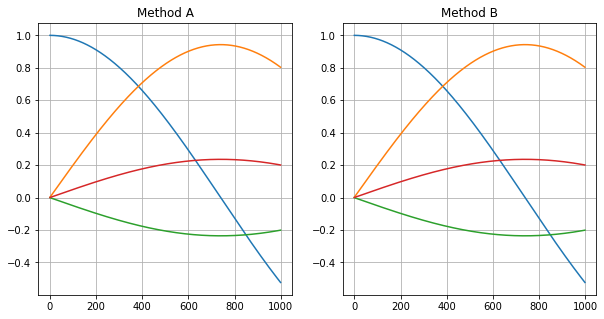

In [3]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(qaa)
plt.grid(True)
plt.title("Method A")

plt.subplot(1,2,2)
plt.plot(qbb)
plt.grid(True)
plt.title("Method B");